# Training and Fine-Tuning BERT for Classification
## Classfying Goodreads Reviews By Book Genre

By Maria Antoniak, Melanie Walsh, and the [BERT for Humanists](https://melaniewalsh.github.io/BERT-for-Humanists/) Team 

*Modified by Lauren Klein for Emory ENG 790 / QTM 490 (Spring 2023)*

<br></br>

This notebook will demonstrate how users can train and fine-tune a BERT model for classification with the popular HuggingFace `transformers` Python library.

We will fine-tune a BERT model on Goodreads reviews from the [UCSD Book Graph](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/reviews?authuser=0) with the goal of predicting the genre of the book being reviewed. The genres include:
- poetry
- comics & graphic
- fantasy & paranormal
- history & biography
- mystery, thriller, & crime
- romance
- young adult  

**Basic steps involved in using BERT and HuggingFace:**
1. Divide your data into training and test sets.
2. Encode your data into a format BERT will understand.
3. Combine your data and labels into datset objects.
4. Load the pre-trained BERT model.
5. Fine-tune the model using your training data.
6. Predict new labels and evaluate performance on your test data.



<br><br>

## **Import necessary Python libraries and modules**

First, we will import necessary Python libraries and modules. These include as `gdown`, for downloading large files from Google Drive (where we will get our UCSD Goodreads reviews), as well as scikit-learn (`sklearn`) and PyTorch (`torch`), for various machine learning tools.

In [ ]:
# upgrade gdown for downloading large files from Google Drive
# we'll need to restart after this

!pip install --upgrade --no-cache-dir gdown

In [ ]:
# Basic Python modules
from collections import defaultdict
import random
import pickle

# For downloading large files from Google Drive
# https://github.com/wkentaro/gdown
import gdown

# For working with gzip files
# https://docs.python.org/3/library/gzip.html
import gzip

# For working with JSON files
import json

# For data manipulation and analysis
import pandas as pd
import numpy as np

# For machine learning tools and evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# For deep learning
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
import torch

# For plotting and data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)

To use the HuggingFace [`transformers` Python library](https://huggingface.co/transformers/installation.html), we will install it with `pip`.

In [ ]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Once `transformers` is installed, we will import modules for `DistilBert`, a *distilled* or smaller version of a BERT model that runs more quickly and uses less computing power. This makes it ideal for those just getting started with BERT.

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

<br><br>

## **Set parameters and file paths**

In [ ]:
# This is the name of the BERT model that we want to use. 
# We're using DistilBERT to save space (it's a distilled version of the full BERT model), 
# and we're going to use the cased (vs uncased) version.
model_name = 'distilbert-base-cased'  

# This is the name of the program management system for NVIDIA GPUs. We're going to send our code here.
device_name = 'cuda'       

# This is the maximum number of tokens in any document sent to BERT.
max_length = 512                                                        

# This is the name of the directory where we'll save our model. You can name it whatever you want.
cached_model_directory_name = 'distilbert-reviews-genres'  

<br><br>

## **Load our sampled Goodreads data**

In this cell, we download (from Lauren's Google Drive) a "pickle" version of a Python dictionary that contains 16,000 randomly sampled reviews from GoodReads--2000 from each of the following eight genres: poetry, children, comics_graphic, fantasy_paranormal, history_biography, mystery_thriller_crime, romance, and young_adult. 

In [ ]:
gdown.download('https://drive.google.com/uc?export=download&id=10eHwWcToq4kys_cnA3lQgs8DzK99H2NP', quiet=False) 

with open('genre_reviews_dict.pkl', 'rb') as f:
    genre_reviews_dict = pickle.load(f)

Downloading...
From: https://drive.google.com/uc?export=download&id=10eHwWcToq4kys_cnA3lQgs8DzK99H2NP
To: /content/genre_reviews_dict.pkl
100%|██████████| 10.5M/10.5M [00:01<00:00, 8.86MB/s]


Let's preview a couple of the key-value pairs in `genre_reviews_dict`

In [ ]:
 for _genre, _reviews in genre_reviews_dict.items():
    print(_genre)
    print(random.sample(_reviews, 1)[0])

poetry
Hbbt d`wh llTfwlh , khsrh shy'`h jd <3 
 tb lkm Hbb lktb klh
children
Puedo volver a ser chica solo para leer este libro? No es que sea la obra maestra mas grande, pero el humor y los tiempos que maneja Dahl me parecen insuperables si hablamos de libros infantiles. Sin lugar a dudas ya se que voy a leerle a los crios para que se vuelvan igual de malvados que yo.
comics_graphic
I received this book for free through Goodreads First Reads. In no way does that influence this review. 
 First off, the artwork is absolutely beautiful. The colored pages at the start of each volume are amazing. I really enjoyed the story, it's very different than most manga I read. Page after page, I just couldn't put it down. It was so interesting, I just had to know what was going to happen. The story will keep you on the edge of your seat. You won't be disappointed with the ending. I thought I knew what was going to happen and I was completely wrong. I definitely recommend reading this manga and exper

<br><br>

## **Split the data into training and test sets**

When training a machine learning model, it is necessary to split your training data into two parts: a "training" set and a "test" set.

We will train our BERT model on the "training" set of Goodreads reviews and then we will evaluate how well it is performing by running it on the "test" set of Goodreads reviews that the model has never seen before.

Normally, to tune the hyperparameters, you should also create a "validation" set for tuning, and only use the "test" set once, at the end of all tuning. For simplicity, in this tutorial, we will only using a training and test set.

In [ ]:
train_texts = []
train_labels = []

test_texts = []
test_labels = []

for _genre, _reviews in genre_reviews_dict.items():

  _reviews = random.sample(_reviews, 1000) # Use a very small set as an example.
  
  for _review in _reviews[:800]:
    train_texts.append(_review)
    train_labels.append(_genre)
  for _review in _reviews[800:]:
    test_texts.append(_review)
    test_labels.append(_genre)

Show how many Goodreads reviews and labels we have in each category: 6400 training reviews, 6400 training labels (genres), 1600 test reviews, 1600 test labels (genre)

In [ ]:
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(6400, 6400, 1600, 1600)

Here's an example of a training label and review:

In [ ]:
train_labels[0], train_texts[0]

('poetry',
 "The Tighty Whitey Spider is quite possibly one of the cutest poetry book I have ever seen for kids. Almost every poem has an adorable illustration to go along with the poem, which will undoubtedly help keep your child's attention. In addition, some of these poems are downright hilarious. I found myself laughing out loud on a number of these poems. \n If the hilarious poems and adorable illustrations were not enough, there is also a free audio download available. In this audio, readers can listen along as the author reads (and even sings) some of the poems. I took a few minutes to listen to the audio, and have to say that it is a great accompaniment to the novel. The Tighty Whitey Spider would be a great addition to any parent's library who is wanting to introduce poetry to their younger children or expand on their relationship with poetry.")

<br><br>

## **Run a baseline model (logistic regression)**

Here we train and evaluate a simple TF-IDF baseline model using logistic regression.

We find better-than-random performance, even for a very small dataset. We'll see whether BERT can beat this good baseline!

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

We train a logistic regression model from scikit-learn on the Goodreads training data, and then we use the trained model to make predictions on our Goodreads review test set.

In [ ]:
model = LogisticRegression(max_iter=1000).fit(X_train, train_labels)
predictions = model.predict(X_test)

We can use scikit-learn's `classification_report` function to evaluate how well the logistic regression model's predictions match up with the true labels for the Goodreads reviews. 

Importantly, we can see that our average scores are above random performance (we have 8 classes, so random performance would be ~0.2). 

In [ ]:
print(classification_report(test_labels, predictions))

                        precision    recall  f1-score   support

              children       0.62      0.60      0.61       200
        comics_graphic       0.60      0.59      0.60       200
    fantasy_paranormal       0.35      0.30      0.33       200
     history_biography       0.53      0.44      0.48       200
mystery_thriller_crime       0.55      0.54      0.54       200
                poetry       0.56      0.69      0.62       200
               romance       0.47      0.52      0.49       200
           young_adult       0.39      0.40      0.40       200

              accuracy                           0.51      1600
             macro avg       0.51      0.51      0.51      1600
          weighted avg       0.51      0.51      0.51      1600



<br><br>

## **Encode data for BERT**

We're going to transform our texts and labels into a format that BERT (via Huggingface and PyTorch) will understand. This is called *encoding* the data.

Here are the steps we need to follow:

1. The labels&mdash;in this case, Goodreads genres&mdash;need to be turned into integers rather than strings.

2. The texts&mdash;in this case, Goodreads reviews&mdash;need to be truncated if they're more than 512 tokens or padded if they're fewer than 512 tokens. The tokens, or words in the texts, also need to be separated into "word pieces" and matched to their embedding vectors.

3. We need to add special tokens to help BERT:

| BERT special token | Explanation |
| --------------| ---------|
| [CLS] | Start token of every document. |
| [SEP] | Separator between each sentence |
| [PAD] | Padding at the end of the document as many times as necessary, up to 512 tokens |
|  &#35;&#35; | Start of a "word piece" |




Here we will load `DistilBertTokenizerFast` from the HuggingFace library, which will do all the work of encoding the texts for us. The `tokenizer()` will break word tokens into word pieces, truncate to 512 tokens, and add padding and special BERT tokens.

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name) # The model_name needs to match our pre-trained model.

Here we will create a map of our labels, or Goodreads genres, to integer keys. We take the unique labels, and then we make a dictionary that associates each label/tag with an integer.

**Note:** HuggingFace documentation sometimes refers to "labels" as "tags" but these are the same thing. We use "labels" throughout this notebook for clarity.

In [ ]:
unique_labels = set(label for label in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [ ]:
label2id.keys()

dict_keys(['mystery_thriller_crime', 'fantasy_paranormal', 'young_adult', 'history_biography', 'poetry', 'romance', 'comics_graphic', 'children'])

In [ ]:
id2label.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

Now let's encode our texts and labels!

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

**Examine a Goodreads review in the training set after encoding**

In [ ]:
' '.join(train_encodings[0].tokens[0:100])

"[CLS] The T ##ight ##y White ##y Spider is quite possibly one of the cute ##st poetry book I have ever seen for kids . Almost every poem has an adorable illustration to go along with the poem , which will undoubtedly help keep your child ' s attention . In addition , some of these poems are down ##right hi ##lar ##ious . I found myself laughing out loud on a number of these poems . If the hi ##lar ##ious poems and adorable illustrations were not enough , there is also a free audio download available . In"

**Examine a Goodreads review in the test set after encoding**

In [ ]:
' '.join(test_encodings[0].tokens[0:100])

'[CLS] Reading this book is add ##ict ##ing and amazing . I like to read him while cooking dinner especially aloud . The " Me ##rmaid " poem is fantastic . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

**Examine the training labels after encoding**

In [ ]:
set(train_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

**Examine the test labels after encoding**

In [ ]:
set(test_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

<br><br>

## **Make a custom Torch dataset**

Here we combine the encoded labels and texts into dataset objects. We use the custom Torch `MyDataSet` class to make a `train_dataset` object from  the `train_encodings` and `train_labels_encoded`. We also make a `test_dataset` object from `test_encodings`, and `test_labels_encoded`.

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

**Examine a Goodreads review in the Torch `training_dataset` after encoding**

In [ ]:
' '.join(train_dataset.encodings[0].tokens[0:100])

"[CLS] The T ##ight ##y White ##y Spider is quite possibly one of the cute ##st poetry book I have ever seen for kids . Almost every poem has an adorable illustration to go along with the poem , which will undoubtedly help keep your child ' s attention . In addition , some of these poems are down ##right hi ##lar ##ious . I found myself laughing out loud on a number of these poems . If the hi ##lar ##ious poems and adorable illustrations were not enough , there is also a free audio download available . In"

**Examine a Goodreads review in the Torch `test_dataset` after encoding**

In [ ]:
' '.join(test_dataset.encodings[1].tokens[0:100])

'[CLS] By turns rib ##ald , funny , sober ##ing , thought pro ##voking and con ##tra ##dict ##ory , this book gives little insights by various authors , playwright ##s , socialist ##s , actors et al . about the oldest profession that is ever new . While it gives no advice about how to deal with the sexes , it does shed a cheer ##y light on a subject that often takes place in the dark . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

<br><br>

## **Load pre-trained BERT model**

Here we load a pre-trained DistilBERT model and send it to CUDA.

**Note:** If you decide to repeat fine-tuning after already running the following cells, make sure that you re-run this cell to re-load the original pre-trained model before fine-tuning again.

In [ ]:
# The model_name needs to match the name used for the tokenizer above.
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bia

<br><br>

## **Set the BERT fine-tuning parameters**

These are the arguments we'll set in the HuggingFace TrainingArguments objects, which we'll then pass to the HuggingFace Trainer object. There are many more possible arguments, but here we highlight the basics and some common gotchas.

When training your own model, you should search over these parameters to find the best settings for your particular dataset. You should use a held-out set of validation data for this step.

| Parameter | Explanation |
|-----------| ------------|
| num_train_epochs | total number of training epochs (how many times to pass through the entire dataset; too much can cause overfitting) |
| per_device_train_batch_size | batch size per device during training |
| per_device_eval_batch_size |  batch size for evaluation |
|  warmup_steps |  number of warmup steps for learning rate scheduler (set lower because of small dataset size) |
| weight_decay | strength of weight decay (reduces size of weights, like regularization) |
| output_dir | output directory for the fine-tuned model and configuration files |
| logging_dir | directory for storing logs |
| logging_steps | how often to print logging output (so that we can stop training early if the loss isn't going down) |
| evaluation_strategy | evaluate while training so that we can see the accuracy going up |

In [ ]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

<br><br>

## **Fine-tune the BERT model**

First, we define a custom evaluation function that returns the accuracy. You could modify this function to return precision, recall, F1, and/or other metrics.

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

Then we create a HuggingFace `Trainer` object using the `TrainingArguments` object that we created above. We also send our `compute_metrics` function to the `Trainer` object, along with our test and train datasets.

**Note:** This is what we've been aiming for this whole time! All the work of tokenizing, creating datasets, and setting the training arguments was for this cell.

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset (usually a validation set; here we just send our test set)
    compute_metrics=compute_metrics      # our custom evaluation function 
)

Time to finally fine-tune! 

Be patient; if you've set everything in Colab to use GPUs, then it should only take a minute or two to run, but if you're running on CPU, it can take hours.

After every 10 steps (as we specified in the TrainingArguments object), the trainer will output the current state of the model, including the training loss, validation ("test") loss, and accuracy (from our `compute_metrics` function).

You should see the loss going down and the accuracy going up. If instead they are staying the same or oscillating, you probably need to change the fine-tuning parameters.

In [ ]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6400
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1200
  Number of trainable parameters = 65787656


Step,Training Loss,Validation Loss,Accuracy
100,2.017600,1.737678,0.391250
200,1.560100,1.399415,0.486875
300,1.471100,1.369355,0.495000
400,1.386100,1.309444,0.507500
500,1.139600,1.331738,0.522500
600,1.093300,1.270652,0.543125
700,1.073700,1.258200,0.543750
800,1.077600,1.249207,0.550000
900,0.778500,1.288712,0.553750
1000,0.731500,1.321913,0.550000


***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.jso

TrainOutput(global_step=1200, training_loss=1.1494062105814615, metrics={'train_runtime': 1209.9336, 'train_samples_per_second': 15.869, 'train_steps_per_second': 0.992, 'total_flos': 2543646198988800.0, 'train_loss': 1.1494062105814615, 'epoch': 3.0})

<br><br>

## **Save fine-tuned model**

The following cell will save the model and its configuration files to a directory in Colab. To preserve this model for future use, you should download the model to your computer.

In [ ]:
trainer.save_model(cached_model_directory_name)

(Optional) If you've already fine-tuned and saved the model, you can reload it using the following line. You don't have to run fine-tuning every time you want to evaluate.

In [ ]:
# trainer = DistilBertForSequenceClassification.from_pretrained(cached_model_directory_name)

<br><br>

## **Evaluate fine-tuned model**

The following function of the `Trainer` object will run the built-in evaluation, including our `compute_metrics` function.

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20


{'eval_loss': 1.3106741905212402,
 'eval_accuracy': 0.56875,
 'eval_runtime': 25.6821,
 'eval_samples_per_second': 62.3,
 'eval_steps_per_second': 3.115,
 'epoch': 3.0}

But we might want to do more fine-grained analysis of the model, so we extract the predicted labels.

In [ ]:
predicted_results = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 1600
  Batch size = 20


In [ ]:
predicted_results.predictions.shape

(1600, 8)

In [ ]:
predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability

In [ ]:
len(predicted_labels)

1600

In [ ]:
print(classification_report(test_labels, 
                            predicted_labels))

                        precision    recall  f1-score   support

              children       0.66      0.64      0.65       200
        comics_graphic       0.71      0.62      0.66       200
    fantasy_paranormal       0.45      0.45      0.45       200
     history_biography       0.52      0.56      0.53       200
mystery_thriller_crime       0.57      0.64      0.60       200
                poetry       0.70      0.68      0.69       200
               romance       0.53      0.51      0.52       200
           young_adult       0.45      0.46      0.46       200

              accuracy                           0.57      1600
             macro avg       0.57      0.57      0.57      1600
          weighted avg       0.57      0.57      0.57      1600



<br><br>

## **Pull out correct and incorrect classifications for examination**

Let's use our predicted labels for some analysis!

Now that we've fine-tuned and pulled out our predicted labels, the BERT part of this tutorial is done. You can now use the predicted labels in the same way you would use any set of predicted labels from any classification model. We'll show some examples here.

First, let's print out some example predictions that were correct.

In [ ]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label == _predicted_label:
    print('LABEL:', _true_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

LABEL: children
REVIEW TEXT: Not a bad book to have on your shelf when you need a quick idea and are feeling brain dead. I liked  ...

LABEL: poetry
REVIEW TEXT: I am been reading this collection of poetry on and off since I was first assigned to read this for a ...

LABEL: comics_graphic
REVIEW TEXT: When a comic store discussion kicks up about Mike Grell's GreenArrow: The Longbow Hunters, there is  ...

LABEL: comics_graphic
REVIEW TEXT: Graphic novel writing and reading at its best! Spiegelman has created an amazingly innovative presen ...

LABEL: children
REVIEW TEXT: This book was my childhood >.< ...

LABEL: young_adult
REVIEW TEXT: Ok so here we go... 
 I see you there thinking "it's just another of those depressing cancer books,  ...

LABEL: children
REVIEW TEXT: I had forgotten that there was a new Clementine coming out this fall and when I saw it on the New Ar ...

LABEL: young_adult
REVIEW TEXT: Like several others, I was drawn to I Am Number Four after seeing the movie prev

Now let's print out some misclassifications.

In [ ]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label != _predicted_label:
    print('TRUE LABEL:', _true_label)
    print('PREDICTED LABEL:', _predicted_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

TRUE LABEL: comics_graphic
PREDICTED LABEL: fantasy_paranormal
REVIEW TEXT: Great follow up finishing Vladek's story through the war. Powerful. ...

TRUE LABEL: young_adult
PREDICTED LABEL: mystery_thriller_crime
REVIEW TEXT: Just as terrifying as Crank. I loved the unresolved ending. ...

TRUE LABEL: romance
PREDICTED LABEL: young_adult
REVIEW TEXT: Players and Princes 
 This book is so tense at ending. Why? Why? Tia Louise!!!! Please tell me that  ...

TRUE LABEL: history_biography
PREDICTED LABEL: comics_graphic
REVIEW TEXT: Una buenisima lectura. 
 En este libro, Arturo Perez-Reverte cuenta la historia o la aventura de los ...

TRUE LABEL: children
PREDICTED LABEL: poetry
REVIEW TEXT: Funny poetry readaloud for teens ...

TRUE LABEL: young_adult
PREDICTED LABEL: fantasy_paranormal
REVIEW TEXT: Still Dark and Disturbing ... 
 Catching Fire is the second book of the Hunger Games Trilogy. Though ...



Finally, let's create some heatmaps to examine misclassification patterns. We could use these patterns to think about similarities and differences between genres, according to book reviewers.

In [ ]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
  genre_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre', 
                                 columns='Predicted Genre', 
                                 values='Number of Classifications')

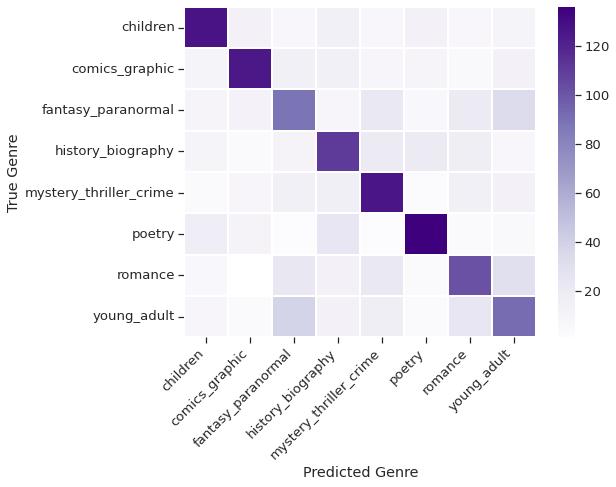

In [ ]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Looks good! We can see that overall, our model is assigning the correct labels for each genre. 

Now, let's remove the diagonal from the plot to highlight the misclassifications.

In [ ]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
  if _true_label != _predicted_label: # Remove the diagonal to highlight misclassifications
    genre_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre', 
                                 columns='Predicted Genre', 
                                 values='Number of Classifications')

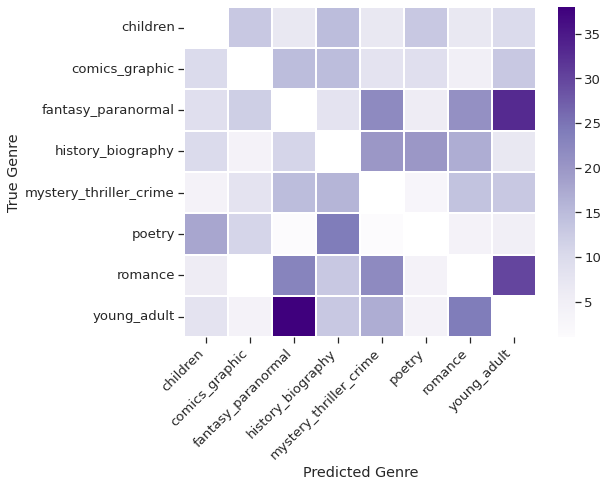

In [ ]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

There's much more you can do with your own dataset and labels! Classification can be used to apply a small set of labels across a big dataset; to explore misclassifications to better understand users; and much more! We hope you'll use this tutorial in all kinds of creative ways.